# Setup

In [42]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, length, trim, lower, regexp_replace, udf, array_contains, array_remove,
    explode, split, size, avg, count, desc, concat_ws, row_number
)
from pyspark.sql.window import Window
from pyspark.sql.types import ArrayType, StringType, FloatType
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF, PCA, NGram, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

In [2]:
# Download NLTK data (needed for the lemmatizer)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("IMDbDataProcessing") \
    .getOrCreate()

spark

# 1. Load the data

- Loading the IMDb Dataset CSV file with the following options:
  - use the first row as headers
  - analyse the column data and recognise the data types
  - consider the column data to be enclosed in quotes, so that the review containing comma in it wont be interpreted as separate column
  - If a review in itself contains a quote inside, correctly consider it instead of delimiting the column

In [4]:
file_path = "/content/IMDB Dataset.csv"

# Loading the dataset into a pyspark.sql.dataframe.DataFrame instance
df = spark.read.csv(file_path,
                    header=True,
                    inferSchema=True,
                    quote='"',
                    escape='"')

# 2. Explore the Data

- Understanding the structure and contents of the dataset
- Number and nature of columns

In [5]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 50000
Number of columns: 2


### 2.1 Print the schema

In [6]:
print("DataFrame Schema:")
df.printSchema()

DataFrame Schema:
root
 |-- review: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
df.dtypes

### 2.2 Display first 5 rows

In [7]:
print("First 5 rows (full text):")
df.show(5, truncate=False)

First 5 rows (full text):
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
print("First 5 rows (truncated text):")
df.show(5)

First 5 rows (truncated text):
+--------------------+---------+
|              review|sentiment|
+--------------------+---------+
|One of the other ...| positive|
|A wonderful littl...| positive|
|I thought this wa...| positive|
|Basically there's...| negative|
|Petter Mattei's "...| positive|
+--------------------+---------+
only showing top 5 rows



### 2.3 Check data quality and distribution

In [8]:
print("Sentiment value distribution:")
df.groupBy("sentiment").count().show()

Sentiment value distribution:
+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+



# 3. Clean the data

### 3.1 Remove HTML tags
With regex expression - <[^>]*>

In [10]:
df_clean = df.withColumn("review_clean",
    regexp_replace(col("review"), "<[^>]*>", " ")
)

### 3.2 Remove URLs

In [11]:
df_clean = df_clean.withColumn("review_clean",
    regexp_replace(col("review_clean"), r"http[s]?://\S+|www\.\S+", "")
)

### 3.3 Remove special characters, handle line breaks & tab spaces

In [12]:
# Replace line breaks and tab spaces with a single space
df_clean = df_clean.withColumn("review_clean",
    regexp_replace(col("review_clean"), r"\s+", " ")
)

# Remove punctuation, numbers, and keep only letters and spaces
df_clean = df_clean.withColumn("review_clean",
    regexp_replace(col("review_clean"), "[^a-zA-Z ]", "")
)

### 3.4 Convert all text to lowercase

In [13]:
df_clean = df_clean.withColumn("review_clean",
    lower(col("review_clean"))
)

### 3.5 Tokenisation

In [14]:
# Split reviews into individual words
df_clean = df_clean.withColumn("words", split(col("review_clean"), " "))

### 3.6 Removing stopwords

In [15]:
# Using PySpark ML's StopWordsRemover to filter out common,
# non-informative words (like 'a', 'the', 'is', 'in').
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_clean = remover.transform(df_clean)

# Join the array of strings in the "filtered_words" column into a single string
df_clean = df_clean.withColumn("review_filtered",
    concat_ws(" ", col("filtered_words"))
)

In [16]:
df_clean

DataFrame[review: string, sentiment: string, review_clean: string, words: array<string>, filtered_words: array<string>, review_filtered: string]

### 3.7 Remove null or empty reviews

In [17]:
# Removing rows that have null review using dropna
# And removing the rows that have empty reviews ""
df_clean = df_clean.dropna(subset=["review_filtered"]) \
                   .filter(trim(col("review_filtered")) != "")

print("Cleaning complete. New columns review_clean: string, words: array<string>, filtered_words: array<string>, review_filtered: string added.")
df_clean.show(5)

Cleaning complete. New columns review_clean: string, words: array<string>, filtered_words: array<string>, review_filtered: string added.
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|              review|sentiment|        review_clean|               words|      filtered_words|     review_filtered|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|One of the other ...| positive|one of the other ...|[one, of, the, ot...|[one, reviewers, ...|one reviewers men...|
|A wonderful littl...| positive|a wonderful littl...|[a, wonderful, li...|[wonderful, littl...|wonderful little ...|
|I thought this wa...| positive|i thought this wa...|[i, thought, this...|[thought, wonderf...|thought wonderful...|
|Basically there's...| negative|basically theres ...|[basically, there...|[basically, there...|basically theres ...|
|Petter Mattei's "...| positive|petter matte

# 4. Analyse the Data

### 4.1 Total number of reviews

In [18]:
total_count = df_clean.count()
print(f"Total number of clean reviews: {total_count}")

Total number of clean reviews: 50000


### 4.2 Count reviews by sentiment

In [19]:
print("Clean sentiment distribution:")
sentiment_counts = df_clean.groupBy("sentiment").count()
sentiment_counts.show()

Clean sentiment distribution:
+---------+-----+
|sentiment|count|
+---------+-----+
| positive|25000|
| negative|25000|
+---------+-----+



### 4.3 Display the rows with highest no of stopwords, URLs, HTML tags, special characters and unwanted characters

This gives a clear picture of how the data cleaning was effective, and shows the original review (with unwanted characters, needless info) VS the filtered review after data cleaning

In [20]:
# Display the top 3 rows with maximum difference in text between "review" and "review_filtered" columns
df_diff = df_clean.withColumn("text_diff",
    length(col("review")) - length(col("review_filtered"))
)

df_diff = df_diff.orderBy(desc("text_diff")).select("review", "review_filtered", "text_diff").limit(3).toPandas()
styled_df = df_diff.style.set_properties(
    **{
        'white-space': 'pre-wrap',
        'text-align': 'left',
        'width': '1000px',
        'vertical-align': 'top'
    }
).set_table_styles(
    [dict(selector="th", props=[("text-align", "left")])]
)
display(styled_df)

# 5. Transform and Feature Engg

### 5.1 Column for length of each review

In [21]:
# Using our 'review_filtered' column for an accurate length of useful words.
df_features = df_clean.withColumn("review_length", length(col("review_filtered")))

### 5.2 Column for word count for each review

In [23]:
# Create word_count column for an accurate count of useful words
df_features = df_features.withColumn("words_count",
    size(col("filtered_words"))
)

In [24]:
df_features.show(5)

+--------------------+---------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+
|              review|sentiment|        review_clean|               words|      filtered_words|     review_filtered|review_length|words_count|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+
|One of the other ...| positive|one of the other ...|[one, of, the, ot...|[one, reviewers, ...|one reviewers men...|         1143|        166|
|A wonderful littl...| positive|a wonderful littl...|[a, wonderful, li...|[wonderful, littl...|wonderful little ...|          656|         84|
|I thought this wa...| positive|i thought this wa...|[i, thought, this...|[thought, wonderf...|thought wonderful...|          580|         86|
|Basically there's...| negative|basically theres ...|[basically, there...|[basically, there...|basically theres ...|          458|         72|

In [25]:
df_features.select(["review_length", "words_count"]).describe().show()

+-------+-----------------+-----------------+
|summary|    review_length|      words_count|
+-------+-----------------+-----------------+
|  count|            50000|            50000|
|   mean|        827.29614|        120.24452|
| stddev|639.6723162483631|90.61886164332086|
|    min|               17|                3|
|    max|             9206|             1428|
+-------+-----------------+-----------------+



### 5.3 Text Lemmatisation

Lemmatization - Extraction of the base word from the word usage in the sentence. Using the lemmas instead of the word gives us the following advantages:
- Better context awareness: Focuses on capturing the meaning of the word more effectively
- Reduces vocabulary size: It groups different forms of a word (like movies, movie's, and movie) into a single base form (movie). This drastically shrinks the feature vector, making it less sparse and more efficient.
- More accurate TF-IDF scores: By consolidating all variations of the word, it increases the frequency and TF-IDF score of the core lemma.
- Improves Model Accuracy: It learns that n-grams like really good movie and really good movies mean the same thing, allowing it to have better generalised model.

UDF - User Defined Function is the special wrapper/ bridge that allows custom Python code to run in PySpark's distributed environment. It broadcasts the function utilities to every single worker node in the cluster and executes the function in parallel on each partition of the data.

In [26]:
def lemmatize_word_list(word_list):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in word_list]

# Register the function as a PySpark UDF
lemmatizer_udf = udf(lemmatize_word_list, ArrayType(StringType()))

df_features = df_features.withColumn(
    "lemmatized_words",
    lemmatizer_udf(col("filtered_words"))
)

In [43]:
# Remove all empty strings if present in the lemmatized words column (array of strings)
df_features = df_features.withColumn("lemmatized_words", array_remove(col("lemmatized_words"), ""))
df_features = df_features.withColumn("lemmatized_words", array_remove(col("lemmatized_words"), " "))

In [27]:
print("Lemmatization Results:")
df_features.select("filtered_words", "lemmatized_words").show(10)

Lemmatization Results:
+--------------------+--------------------+
|      filtered_words|    lemmatized_words|
+--------------------+--------------------+
|[one, reviewers, ...|[one, reviewer, m...|
|[wonderful, littl...|[wonderful, littl...|
|[thought, wonderf...|[thought, wonderf...|
|[basically, there...|[basically, there...|
|[petter, matteis,...|[petter, matteis,...|
|[probably, alltim...|[probably, alltim...|
|[sure, like, see,...|[sure, like, see,...|
|[show, amazing, f...|[show, amazing, f...|
|[encouraged, posi...|[encouraged, posi...|
|[like, original, ...|[like, original, ...|
+--------------------+--------------------+
only showing top 10 rows



In [45]:
# Join the array of strings in the "review_lemmatized" column into a single string
df_features = df_features.withColumn("review_lemmatized",
    concat_ws(" ", col("lemmatized_words"))
)

### 5.4 Vectorisation - TF-IDF

Key Info:
- Vectorization - translates the list of lemmatized words into a numerical vector that machine learning models can understand.

- TF-IDF vectorisation - creates a score that measures how important a word is to the review.

- Term Frequency (TF): How often does a word appear in a single review?

- Inverse Document Frequency (IDF): How rare or common is that word across all 50,000 reviews?

- TF-IDF Score: is calculated by multiplying these two numbers. A word gets the highest score if it appears frequently in one review (high TF) but is rare overall (high IDF).

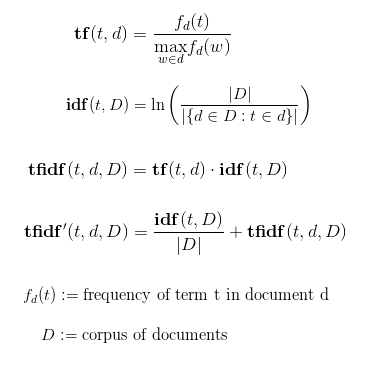


Need for TF-IDF vectorisation:
- To Feed the model: PySpark ML model cannot process words/lemmas directly. It requires numerical representation.

- To give importance to the signal, not the noise: TF-IDF automatically punishes the noise (common) words (low IDF score) and boosts the signal (rare/unique) words (high IDF score).
  - A common word like "movie" or "film" will appear in thousands of reviews. It gets a very low IDF score, hence gets lesser importance (noise).
  - A rare word like "brilliant" or "terrible" will appear in fewer reviews. It gets a high IDF score, hence gets higher importance (signal).

In [ ]:
# HashingTF (Term Frequency)
vector_size = 10000
hashingTF = HashingTF(
    inputCol="lemmatized_words",
    outputCol="tf_features",
    numFeatures=vector_size
)

df_features = hashingTF.transform(df_features)

# IDF (Inverse Document Frequency)
idf = IDF(inputCol="tf_features", outputCol="tfidf_features")
idfModel = idf.fit(df_features)
df_features = idfModel.transform(df_features)

In [30]:
print("TF-IDF sparse vector:")
df_features.select("tfidf_features").show(5, truncate=False)

TF-IDF sparse vector:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# 6. Some interesting analysis

### 6.1 Analyze reviews by sentiment

In [31]:
# Are positive reviews longer or denser than negative ones?
print("Average review length and word count by sentiment:")
df_features.groupBy("sentiment") \
    .agg(
        avg("review_length").alias("avg_review_length"),
        avg("words_count").alias("avg_words_count")
    ) \
    .show()


Average review length and word count by sentiment:
+---------+-----------------+---------------+
|sentiment|avg_review_length|avg_words_count|
+---------+-----------------+---------------+
| positive|         843.7912|      121.62704|
| negative|        810.80108|        118.862|
+---------+-----------------+---------------+



Inference Note:
- Positive reviews are very slightly longer (and contain little more words) than negative reviews on average, but the difference is very small.
- The dataset contains equal number of semantics for reviews of both polarity.

### 6.2 Total unique words in vocabulary

In [32]:
unique_words = df_features.select(explode(col("lemmatized_words")).alias("word")).distinct().count()
print(f"Total number of unique words in the vocabulary: {unique_words}")

Total number of unique words in the vocabulary: 151108


### 6.3 Showing the imnportance of data cleaning

In [36]:
rank_window = Window.orderBy(desc("count"))

# 1. Get Top 20 Original Words (from 'words' column)
top_original = df_features \
    .select(explode(col("words")).alias("word")) \
    .filter(col("word") != "") \
    .groupBy("word") \
    .count() \
    .withColumn("rank", row_number().over(rank_window)) \
    .filter(col("rank") <= 20) \
    .select(
        col("rank"),
        col("word").alias("original_word"),
        col("count").alias("original_count")
    )

# 2. Get Top 20 Filtered Words (after removing HTML tags, URLs, stopwords, etc)
top_filtered = df_features \
    .select(explode(col("filtered_words")).alias("word")) \
    .filter(col("word") != "") \
    .groupBy("word") \
    .count() \
    .withColumn("rank", row_number().over(rank_window)) \
    .filter(col("rank") <= 20) \
    .select(
        col("rank"),
        col("word").alias("filtered_word"),
        col("count").alias("filtered_count")
    )

# 3. Get Top 20 Lemmatized Words (after lemmatization of filtered words)
top_lemmatized = df_features \
    .select(explode(col("lemmatized_words")).alias("word")) \
    .filter(col("word") != "") \
    .groupBy("word") \
    .count() \
    .withColumn("rank", row_number().over(rank_window)) \
    .filter(col("rank") <= 20) \
    .select(
        col("rank"),
        col("word").alias("lemmatized_word"),
        col("count").alias("lemmatized_count")
    )

# 4. Join all three DataFrames on their rank
df_comparison = top_original \
    .join(top_filtered, on="rank", how="outer") \
    .join(top_lemmatized, on="rank", how="outer") \
    .orderBy("rank") \
    .select(
        "rank",
        "original_word", "original_count",
        "filtered_word", "filtered_count",
        "lemmatized_word", "lemmatized_count"
    )

# 5. Show the final comparison table
print("Top 20 Words: Original vs. Filtered vs. Lemmatized (Entire Corpus)")
df_comparison.show(truncate=False)

Top 20 Words: Original vs. Filtered vs. Lemmatized (Entire Corpus)
+----+-------------+--------------+-------------+--------------+---------------+----------------+
|rank|original_word|original_count|filtered_word|filtered_count|lemmatized_word|lemmatized_count|
+----+-------------+--------------+-------------+--------------+---------------+----------------+
|1   |the          |664007        |movie        |85233         |movie          |100952          |
|2   |and          |320725        |film         |76033         |film           |91571           |
|3   |a            |320606        |one          |51479         |one            |53810           |
|4   |of           |288488        |like         |39063         |like           |40019           |
|5   |to           |266936        |good         |28913         |time           |30247           |
|6   |is           |210515        |even         |24584         |good           |29030           |
|7   |in           |185075        |time         |23

Inference Note:
- In original words ranking: all unnecessary words (stopwords) are listed, removing these in data preprocessing has made a drastic significance by reducing the corpus size and increasing attention to useful words
- In the filtered words ranking (after removing HTML tags, URLs, stopwords, etc): the word "film" takes second place because the word "films" (count=15538) and "film" (count=76033) are treated as separate words. This problem is solved in lemmatised ranking. Same with "movie" and "movies" (ranked 1 and 20 in filtered words ranking) are combined into the base lemma "movie" in the lemmatised ranking.

### 6.4 Top 20 Most Frequent Words
- Bag of Words to assess the frequency of words in the entire corpus
- Explode the array of filtered words into individual rows
- Count word frequencies and sort in desc order

In [33]:
print("Top 20 POSITIVE Words")
df_features.filter(col("sentiment") == "positive") \
    .select(explode(col("lemmatized_words")).alias("word")) \
    .filter(col("word") != "") \
    .groupBy("word") \
    .count() \
    .orderBy(desc("count")) \
    .show(20)

print("Top 20 NEGATIVE Words")
df_features.filter(col("sentiment") == "negative") \
    .select(explode(col("lemmatized_words")).alias("word")) \
    .filter(col("word") != "") \
    .groupBy("word") \
    .count() \
    .orderBy(desc("count")) \
    .show(20)

Top 20 POSITIVE Words
+---------+-----+
|     word|count|
+---------+-----+
|     film|48750|
|    movie|43925|
|      one|27535|
|     like|17663|
|     time|15638|
|     good|14642|
|    story|13911|
|character|13827|
|    great|12860|
|      see|12649|
|     well|11504|
|      get|11129|
|     make|11009|
|     also|10729|
|   really|10720|
|    scene| 9882|
|     show| 9535|
|     even| 9486|
|     life| 9379|
|     much| 9095|
+---------+-----+
only showing top 20 rows

Top 20 NEGATIVE Words
+---------+-----+
|     word|count|
+---------+-----+
|    movie|57027|
|     film|42821|
|      one|26275|
|     like|22356|
|     even|15099|
|     time|14609|
|     good|14388|
|      bad|14374|
|character|14154|
|      get|13387|
|     make|12613|
|   really|12293|
|    scene|11204|
|      see|11050|
|    story|10827|
|     dont|10282|
|     much|10013|
|   people| 9460|
|    thing| 9376|
|     made| 8473|
+---------+-----+
only showing top 20 rows



Inference Note:
- Many most frequent words are common across positive and negative reviews like "movie", "film", "one", "like", "really", "much", "story", "see"
- The top 20 most frequent words of only positive reviews include: "good", "great", "well", "character"
- The top 20 most frequent words of only negative reviews include: "bad", "dont", "people"

### 6.5 Gram analysis

Since I see the words like "good", "like" in top 20 most frequent words of negative reviews also, I infer that the gram analysis is necessary to get the context of the word usage. It could be "not good", or "not like" in negative reviews, so we cannot just infer from frequency of words, but we should also see the context.

In [44]:
# Initialize the transformer to create tri-grams (n=3)
ngram = NGram(n=3, inputCol="lemmatized_words", outputCol="trigrams")
df_ngrams = ngram.transform(df_features)
print("DataFrame with new 'trigrams' column:")
df_ngrams.select("trigrams").show(5, truncate=False)

DataFrame with new 'trigrams' column:
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
print("Top 20 POSITIVE Tri-Grams")
positive_trigrams = df_ngrams \
    .filter(col("sentiment") == "positive") \
    .select(explode(col("trigrams")).alias("trigram")) \
    .groupBy("trigram") \
    .count() \
    .orderBy(desc("count"))

positive_trigrams.show(20, truncate=False)

print("Top 20 NEGATIVE Tri-Grams")
negative_trigrams = df_ngrams \
    .filter(col("sentiment") == "negative") \
    .select(explode(col("trigrams")).alias("trigram")) \
    .groupBy("trigram") \
    .count() \
    .orderBy(desc("count"))

negative_trigrams.show(20, truncate=False)

Top 20 POSITIVE Tri-Grams
+---------------------------+-----+
|trigram                    |count|
+---------------------------+-----+
|ive ever seen              |363  |
|new york city              |193  |
|film ever made             |165  |
|film ive seen              |164  |
|world war ii               |157  |
|one best movie             |157  |
|one best film              |149  |
|movie ever seen            |148  |
|movie ive seen             |135  |
|based true story           |132  |
|movie ever made            |121  |
|first time saw             |116  |
|best movie ever            |105  |
|first saw movie            |94   |
|movie ive ever             |91   |
|dont get wrong             |91   |
|well worth watching        |90   |
|seen long time             |90   |
|highly recommend movie     |83   |
|international film festival|82   |
+---------------------------+-----+
only showing top 20 rows

Top 20 NEGATIVE Tri-Grams
+-------------------+-----+
|trigram            |count|
+-

Inference Note:
- Some interesting frequent trigrams of "positive" reviews include: "well worth watching", "seen long time", "one best movie", "one best film", "best movie ever", "based true story", "highly recommend movie"
- Some interesting frequent trigrams of "negative" reviews include: "worst movie ever", "movie ever seen", "dont waste time", "one worst movie", "movie ive ever", "worst film ever", "doesnt make sense", "bad acting bad", "complete waste time"
- People mentioned the trigrams "new york city", "world war ii" in top 20 most frequent trigrams of positive reviews, which could suggest that they like this genre of movies, or the sample space of movie reviews focussed on this genre, or it may suggest that people tell the movie story line's focus when they like it.


Looking at the results, I suggest that trigrams validate the context of the feeling towards positive or negative sentiment very clearly than mere word frequency analysis.

# 7. Filter and Display

In [47]:
# Filter and display reviews where the length > 500 characters
print("Reviews with character length > 500:")

df_long_reviews = df_features.filter(col("review_length") > 500) \
                             .select("sentiment", "review_length", "review_clean")

df_long_reviews.show(10)

Reviews with character length > 500:
+---------+-------------+--------------------+
|sentiment|review_length|        review_clean|
+---------+-------------+--------------------+
| positive|         1143|one of the other ...|
| positive|          656|a wonderful littl...|
| positive|          580|i thought this wa...|
| positive|          855|petter matteis lo...|
| negative|          546|this show was an ...|
| negative|          550|i saw this movie ...|
| negative|         1454|so im not a big f...|
| negative|          519|kind of drawn in ...|
| negative|          748|this movie made i...|
| positive|         1232|after the success...|
+---------+-------------+--------------------+
only showing top 10 rows



In [57]:
df_long_reviews.count()

31591

# 8. Save cleaned data

### 8.1 Saving data as a CSV

In [49]:
# Rearrange the columns in the df
df_features = df_features.select('review', 'review_clean', 'review_filtered',
                                 'review_lemmatized', 'review_length', 'words', 'filtered_words',
                                 'lemmatized_words', 'words_count', 'tf_features',
                                 'tfidf_features', 'sentiment')

In [50]:
df_features

DataFrame[review: string, review_clean: string, review_filtered: string, review_lemmatized: string, review_length: int, words: array<string>, filtered_words: array<string>, lemmatized_words: array<string>, words_count: int, tf_features: vector, tfidf_features: vector, sentiment: string]

In [51]:
df_features.show(10)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+---------+
|              review|        review_clean|     review_filtered|   review_lemmatized|review_length|               words|      filtered_words|    lemmatized_words|words_count|         tf_features|      tfidf_features|sentiment|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+-----------+--------------------+--------------------+---------+
|One of the other ...|one of the other ...|one reviewers men...|one reviewer ment...|         1143|[one, of, the, ot...|[one, reviewers, ...|[one, reviewer, m...|        166|(10000,[157,281,3...|(10000,[157,281,3...| positive|
|A wonderful littl...|a wonderful littl...|wonderful little ...|wonderful little ...|       

We have many columns that are array of strings, but we cant store array types in CSV directly. So, select the required columns and convert the vector into string representation for storing in a CSV

In [52]:
vec_to_string_udf = udf(lambda v: str(v), StringType()) # UDF to convert a vector to its string representation

df_to_save = df_features \
    .withColumn("tf_features_string", vec_to_string_udf(col("tf_features"))) \
    .withColumn("tfidf_features_string", vec_to_string_udf(col("tfidf_features")))

df_to_save = df_to_save.drop("tf_features", "tfidf_features", "words", "filtered_words", "lemmatized_words")

In [53]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
# Not coalased, so data in separate partitions (CSVs)
destination_path = '/content/drive/MyDrive/IMDB_Dataset_Cleaned_Partitions'
df_to_save.write \
    .option("header", "true") \
    .mode("overwrite") \
    .option("quoteAll", "true") \
    .csv(destination_path)

Since PySpark is a distributed system, it processes the 50,000 reviews by splitting them into many smaller chunks, called partitions. In the default write method: .write.csv(), each partition is written in parallel to its own separate file.

Hence we use coalesce function to combine all partitions and save into a single CSV file.

In [56]:
# Coalased data into a single CSV
destination_path = '/content/drive/MyDrive/IMDB_Dataset_Cleaned_QuoteEnclosed'
df_to_save.coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .option("quoteAll", "true") \
    .csv(destination_path)

In [198]:
! zip -r IMDB_Dataset_Cleaned.zip IMDB_Dataset_Cleaned

  adding: IMDB_Dataset_Cleaned/ (stored 0%)
  adding: IMDB_Dataset_Cleaned/.part-00000-e96dc8e6-89cf-4e50-ac03-62553a4a73fd-c000.csv.crc (deflated 0%)
  adding: IMDB_Dataset_Cleaned/part-00000-e96dc8e6-89cf-4e50-ac03-62553a4a73fd-c000.csv (deflated 71%)
  adding: IMDB_Dataset_Cleaned/_SUCCESS (stored 0%)
  adding: IMDB_Dataset_Cleaned/._SUCCESS.crc (stored 0%)


In [60]:
# Saving only filtered reviews of length > 500 characters in
destination_path = '/content/drive/MyDrive/IMDB_Dataset_Above500_QuoteEnclosed'

df_to_save_longreviews = df_to_save.filter(col("review_length") > 500)
print(f"Saving {df_to_save_longreviews.count()} long reviews")

df_to_save_longreviews.coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .option("quoteAll", "true") \
    .csv(destination_path)

Saving 31591 long reviews


### 8.2 Saving as a Parquet

In [200]:
df_features.write \
    .mode("overwrite") \
    .parquet("IMDB_Dataset_Cleaned_Parquet")

In [ ]:
! zip -r IMDB_Dataset_Cleaned_Parquet.zip IMDB_Dataset_Cleaned_Parquet

# 9. Data Visualisation

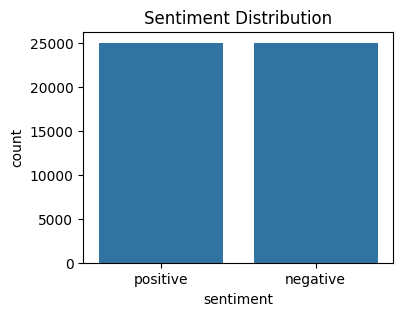

In [ ]:
# Plot Sentiment Distribution
# Convert the small aggregated Spark DataFrame to Pandas
pd_sentiment_counts = sentiment_counts.toPandas()

plt.figure(figsize=(4, 3))
sns.barplot(x="sentiment", y="count", data=pd_sentiment_counts)
plt.title("Sentiment Distribution")
plt.show()

Inference Note:
- The dataset is balanced.
- So, no need of specific sampling methods to select data for modelling

### 9.1 Review Length Distribution

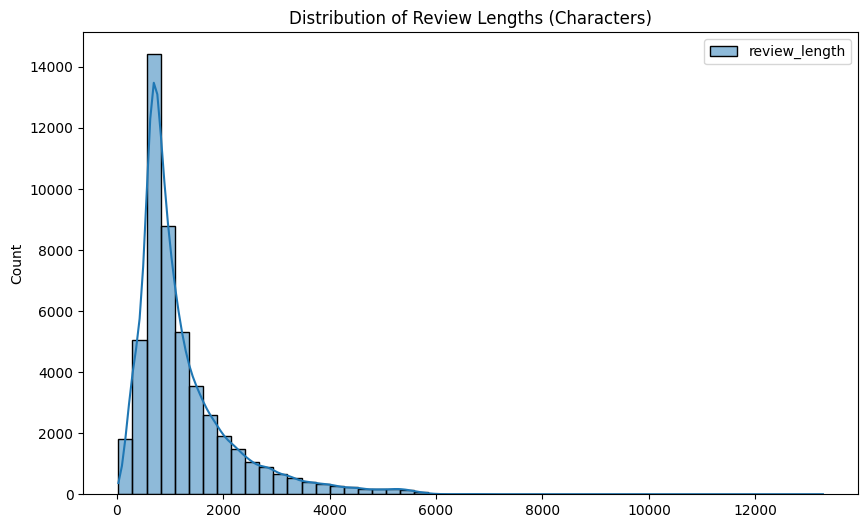

In [ ]:
# Plot Review Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_features.select("review_length").toPandas(), kde=True, bins=50)
plt.title("Distribution of Review Lengths (Characters)")
plt.show()

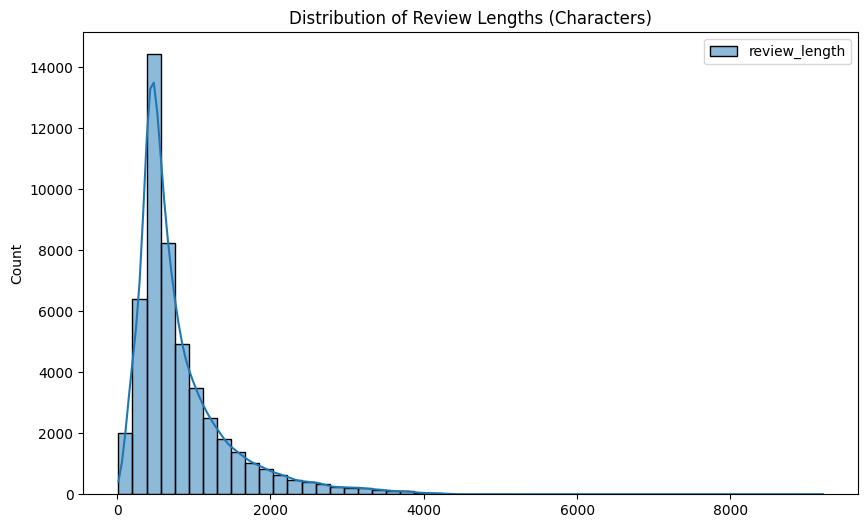

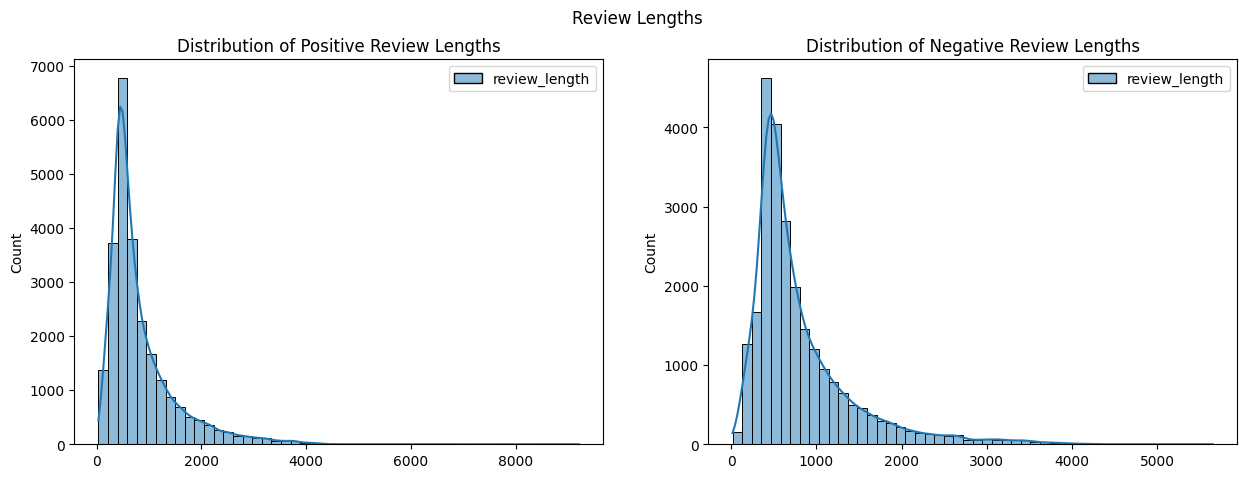

In [202]:
# Plot Review Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_features.select("review_length").toPandas(), kde=True, bins=50)
plt.title("Distribution of Review Lengths (Characters)")
plt.show()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.histplot(df_features.filter(col('sentiment') == 'positive').select("review_length").toPandas(), ax=ax1, kde=True, bins=50, color='Green')
ax1.set_title("Distribution of Positive Review Lengths")
sns.histplot(df_features.filter(col('sentiment') == 'negative').select("review_length").toPandas(), ax=ax2, kde=True, bins=50, color='Red')
ax2.set_title("Distribution of Negative Review Lengths")
fig.suptitle("Review Lengths")
plt.show()

In [203]:
df_features.columns

['review',
 'review_clean',
 'review_filtered',
 'review_lemmatized',
 'review_length',
 'words',
 'filtered_words',
 'lemmatized_words',
 'words_count',
 'tf_features',
 'tfidf_features',
 'sentiment']

### 9.2 Word Cloud

#### Word cloud for positive review words

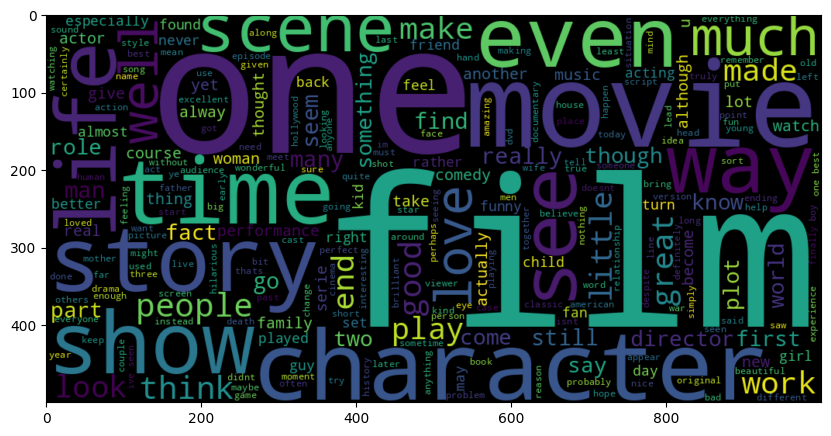

In [62]:
plt.figure(figsize=(10,10))

# Filter positive reviews and collect the 'lemmatized_words' column to a Pandas DataFrame
positive_reviews_pd = df_features.filter(col('sentiment') == 'positive').select('lemmatized_words').toPandas()
positive_text = " ".join(" ".join(word_list) for word_list in positive_reviews_pd['lemmatized_words'])

WC=WordCloud(width=1000,height=500,max_words=250,min_font_size=10)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

#### Word cloud for negative review words

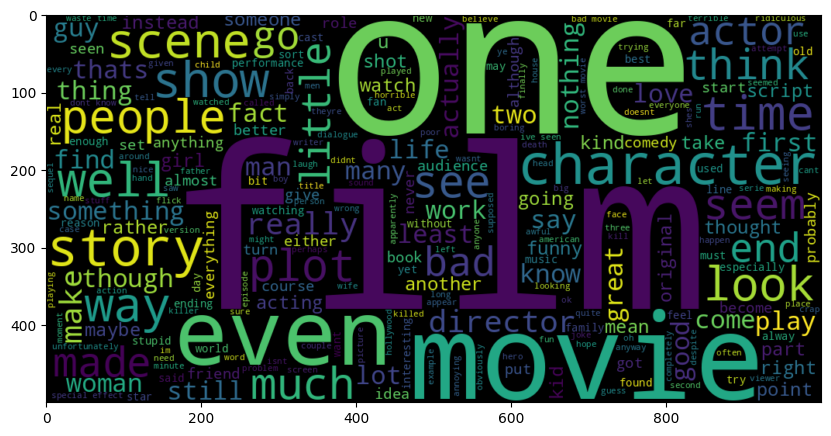

In [63]:
plt.figure(figsize=(10,10))

# Filter negative reviews and collect the 'lemmatized_words' column to a Pandas DataFrame
negative_reviews_pd = df_features.filter(col('sentiment') == 'negative').select('lemmatized_words').toPandas()
negative_text = " ".join(" ".join(word_list) for word_list in negative_reviews_pd['lemmatized_words'])

WC=WordCloud(width=1000,height=500,max_words=250,min_font_size=10)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show()

# 10. PySpark Modelling

### 10.1 Preparing feature vector in the format for PySpark models

In [64]:
df_features

DataFrame[review: string, review_clean: string, review_filtered: string, review_lemmatized: string, review_length: int, words: array<string>, filtered_words: array<string>, lemmatized_words: array<string>, words_count: int, tf_features: vector, tfidf_features: vector, sentiment: string]

In [65]:
# numeric "label" column from "sentiment"
indexer = StringIndexer(inputCol="sentiment", outputCol="label")
indexed_df = indexer.fit(df_features).transform(df_features)

In [66]:
# Required final feature columns
feature_columns = [
    "tfidf_features",  # main text vector
    "review_length",   # numeric feature
    "words_count"      # numeric feature
]

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features"  # This will be the FINAL combined vector
)
final_model_df = assembler.transform(indexed_df)

# Select only the 2 columns needed for modeling
final_model_df = final_model_df.select("features", "label")

print("DataFrame with combined feature vector:")
final_model_df.show(5, truncate=False)

DataFrame with combined feature vector:
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 10.2 Model

In [67]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Split Data
(train_data, test_data) = final_model_df.randomSplit([0.8, 0.2], seed=42)

# Configure Model
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Train Model
model = lr.fit(train_data)

# Evaluate Model
predictions = model.transform(test_data)

In [68]:
# Show a sample of predictions
print("Model Predictions:")
predictions.select("label", "prediction", "probability").show(10)

Model Predictions:
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       1.0|[1.95321693541597...|
|  1.0|       1.0|[1.16355879607933...|
|  0.0|       0.0|           [1.0,0.0]|
|  1.0|       0.0|           [1.0,0.0]|
|  1.0|       1.0|[6.61239504574131...|
|  1.0|       1.0|           [0.0,1.0]|
|  1.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|           [1.0,0.0]|
|  0.0|       0.0|[0.99900731490708...|
+-----+----------+--------------------+
only showing top 10 rows



In [69]:
# Calculate accuracy using AUC
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = evaluator_auc.evaluate(predictions)
print(f"Test Set Area Under ROC (AUC): {auc * 100:.2f}%")

Test Set Area Under ROC (AUC): 87.57%


Note:
The focus of this exercise was not in the direct modelling, but on the pre modelling steps (from data extraction to data cleaning, pre-processing, transformation). Hence a single basic classification model is trained to illustrate the PySpark modelling on the pre-processed data.


In [204]:
spark.stop()